In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def read_file(filename,cols=['Date','Adj Close']):
    """Read in a file name and return dataframe with the specified columns"""
    columns = cols
    df= pd.read_csv(filename, index_col="Date",
                    parse_dates=True,usecols=columns,
                    na_values=['nan'])
    return df


def test_multi_read(folder_path,start_date,
                    end_date,symbols,log=False,
                    cols=['Date','Adj Close']):
    """Load data from path using dictionary of symbols, 
    start and end dates and columns needed"""
    #Define date range
    print("symbols requested: ", symbols)
    dates =  pd.date_range(start_date,end_date)
    print("date range selected:", dates)
    columns = cols
    #Create empty dataframe with dates index
    df1 = pd.DataFrame(index=dates)
    if log==True:
        print(df1)

    for symbol in symbols:
        filename =  folder_path + '{}'.format(symbol) + '.csv'
        if log==True:
             print(filename)
        df_temp = read_file(filename,columns)
        if log==True:
            print(df_temp.head())
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        df1 = df1.join(df_temp, how="inner")
        if log==True:
             print(df1.head())
    return df1

def plot_data(df,title="Stock prices"):
    """Plot the input dataframe df, add axes labels and title """
    ax = df.plot(title=title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()
    
def plot_selected(df, columns, start_index, end_index):
    """Plot the desired columns over index values in the given range."""
    df_temp = df.loc[start_index:end_index,columns]
    plot_data(df_temp)
    
def normalize_data(df):
    """Normalize data with respect to first entry in the dataframe"""
    return df/df.iloc[0,:]

def plot_normalized_data(df,title="Stock prices"):
    """Plot normalized data"""
    df = normalize_data(df)
    ax = df.plot(title=title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.axhline(y=1,color="black",linestyle="--")
    plt.show()
    
def get_rolling_mean(df,window=20,log=False):
    return df.rolling(window).mean()

def get_rolling_sd(df,window=20,log=False):
    return df.rolling(window).std()

def get_bollinger_bands(roll_mean,roll_sd):
    upper_band = roll_mean + roll_sd *2
    lower_band = roll_mean - roll_sd *2
    return upper_band,lower_band

def plot_data_stats(df,window=20,title="Stock prices"):
    """Plot the input dataframe df, add axes labels and title """
    ax = df.plot(title=title)
    rm = get_rolling_mean(df,window)
    rsd = get_rolling_sd(df,window)
    ub,lb =  get_bollinger_bands(rm,rsd)
    colname = rm.columns.values.tolist()
    rm = rm.add_prefix('Rolling Mean_')
    colname = ub.columns.values.tolist()
    ub = ub.add_prefix('Bol_Upper_')
    colname = lb.columns.values.tolist()
    lb = lb.add_prefix('Bol_Lower_')
    ax = rm.plot(ax=ax)
    ax = ub.plot(ax=ax)
    ax = lb.plot(ax=ax)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()  

def get_daily_returns(df,log=False,plot=False):
    daily_returns = ((df / df.shift(1))-1)*100
    daily_returns.iloc[0,:]=0
    if plot==True:
        ax = daily_returns.plot(title="Daily returns")
        ax.set_xlabel("Date")
        ax.set_ylabel("% return")
        plt.show()
    if log==True:
        return daily_returns
    else:
        print("logging disabled")

def get_cumulative_return(df,log=False):
    price_t0 =  df.iloc[0]
    cum_returns = ((df/price_t0)-1)*100
    ax = cum_returns.plot(title="Cumulative returns")
    ax.set_xlabel("Date")
    ax.set_ylabel("% return")
    plt.show()        
    if log==True:
        return cum_returns
    else:
        print("logging disabled")

def daily_returns_stats_single(df,bins=20):
    """
    Single stock stats
    Prints the daily return stats and histogram with mu and +/- 1 sigma
    returns mean, sigma and kurtosis.
    """
    dr = get_daily_returns(df, log=True)
    dr.hist(bins=bins)
    mean = dr.mean()
    sd = dr.std()
    print("Mean      :",mean)
    print("Std Dev   :",sd)
    kurt = dr.kurtosis()
    print("Kurtosis  :",kurt)
    plt.axvline(x=mean,color="white",linestyle="--",linewidth="2")
    plt.axvline(x=mean+sd,color="red",linestyle="--")
    plt.axvline(x=mean-sd,color="red",linestyle="--")
    plt.show()
    return mean,sd,kurt

def daily_returns_stats_multiple(df,bins=20,alpha=0.65,log=True):
    """
    Single stock stats
    Prints the daily return stats and histogram with mu and +/- 1 sigma
    returns mean, sigma and kurtosis in a dataframe
    """
    dr = get_daily_returns(df, log=True)
    symbols = dr.columns.values.tolist()
    for sym in symbols:
        dr[sym].hist(bins=bins,label = sym,edgecolor='k', alpha=alpha)
    mean = dr.mean().values
    sd = dr.std().values
    kurt = dr.kurtosis().values
    output = pd.DataFrame({'mean':mean,'sd':sd,'kurt':kurt},index=symbols)
    if log==True:
        print(output)
    plt.legend(loc='upper right')
    plt.show()
    return output

def daily_scatter_stats(df,symbols=[],log=False):
    """
    Scatterplots and linear regression values for two stocks
    If not specified, the function uses the first two columns
    If log is turned on, beta, alpha values are printed
    Along with the corellation using default pearson method.
    """
    dr = get_daily_returns(df, log=True)
    if not symbols:
        print("Symbol array is empty, selecting the first columns of data frame")
        symbols = dr.columns.values.tolist()
    print(symbols[0],"vs",symbols[1])
    beta,alpha = np.polyfit(dr[symbols[0]],dr[symbols[1]],1)
    if log==True:
        print ("beta_{}".format(symbols[1]), beta)
        print ("alpha_{}".format(symbols[1]), alpha)
    dr.plot(kind='scatter',x=symbols[0],y=symbols[1],edgecolor='k')
    plt.plot(dr[symbols[0]],beta*dr[symbols[0]] + alpha,'-',color="red")
    plt.grid()
    plt.show()
    if log==True:
        print(dr.corr(method='pearson'))
        
def portfolio_returns(df,allocations=[],investment=1000000,plot=True,freq="daily"):
    
    df_norm = normalize_data(df)
    if not allocations:
        cols = df.shape[1]
        equal_alloc=1/cols
        alloc_temp = np.full((1, cols), equal_alloc)
        print("No allocation values provided, allocating equally across all stocks")
    else:        
        alloc_temp = allocations
    symbols = df.columns.values.tolist()
    print("Stock in Portfolio  :",symbols)
    print("Allocations         :",alloc_temp)
    print("Initial Investment  :",investment)
    allocs = df_norm*alloc_temp
    pos_val = allocs * investment
    port_val = pos_val.sum(axis=1)
    net_val = port_val[-1]
    cum_return = ((net_val - investment)/investment)*100
    print("Portfolio Term Value    :",net_val)
    print("Cumulative Term Return  :",cum_return)
    mean,sd,kurt = daily_returns_stats_single(port_val,40)
    if plot==True:
        ax = port_val.plot(title="Portfolio returns")
        ax.grid()
        ax.set_xlabel("Date")
        ax.set_ylabel("$ value")
        ax.axhline(y=investment,color="red")
        plt.show()
    if freq =="weekly":
        const = 52
        print("weekly")
    elif freq =="monthly":
        const = 12
    elif freq == "daily":
        const = 252
    sharpe_ratio = np.sqrt(const)*(mean/sd)
    print("sharpe ratio        :",sharpe_ratio)
    return mean,sd,kurt

symbols requested:  ['SPY', 'GOOG', 'GLD', 'CAT']
date range selected: DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', length=1461, freq='D')
          mean        sd      kurt
SPY   0.059357  1.303258  3.408603
GOOG  0.093666  1.745644  7.141935
GLD   0.069439  1.159167  1.943549
CAT   0.104372  2.400348  2.734872


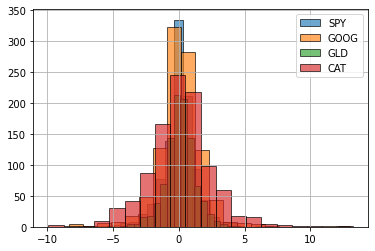

No allocation values provided, allocating equally across all stocks
Stock in Portfolio  : ['SPY', 'GOOG', 'GLD', 'CAT']
Allocations         : [[0.25 0.25 0.25 0.25]]
Initial Investment  : 1000000
Portfolio Term Value    : 1972190.813031006
Cumulative Term Return  : 97.21908130310058
Mean      : 0.07516598248926455
Std Dev   : 1.2359527316864736
Kurtosis  : 1.1313632349738727


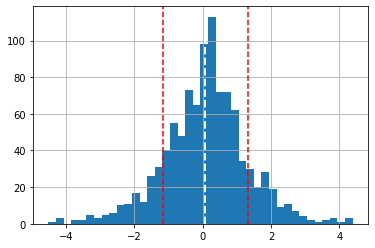

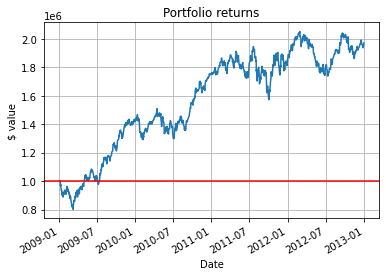

sharpe ratio        : 0.9654276815929766


In [7]:
if __name__ == "__main__":
    sym = ['SPY','GOOG','GLD','CAT']
    fol_path = '../data/raw/'
    strt_date = '2009-01-01'
    fin_date = '2012-12-31'
    cols_selected = ['Date','Adj Close']
    df = test_multi_read(fol_path,strt_date,fin_date,sym,cols=cols_selected)
    daily_returns_stats_multiple(df)
    portfolio_returns(df)
#     daily_scatter_stats(df, log=True)
#     daily_scatter_stats(df,symbols=['SPY','CAT'])
#     for symb in sym :